In [1]:
import pymaster as nmt
import healpy as hp
import numpy as np

import pysm3
import pysm3.units as u

import matplotlib.pyplot as plt

import importlib
import copy
%matplotlib inline

In [2]:
from NPTFit import create_mask as cm # Module for creating masks

In [8]:
import bandpowers
importlib.reload(bandpowers)

<module 'bandpowers' from '/global/u2/j/jianyao/foreground/bandpowers.py'>

In [9]:
from BP_beam_nmt_bin import BPE as BPE_beam
from bandpowers import BPE as BPE

In [3]:
import seaborn as sea
sea.set(rc={'figure.figsize':(11.7,8.27)})
sea.set_style("white")
sea.set_context("talk")
sea.set_style("ticks")

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
nside = 128

In [6]:
mask_spass_256 = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_spass_256.npy')
mask_128 = hp.ud_grade(mask_spass_256, nside_out=128)
mask_128 = np.logical_not(np.logical_not(mask_128))

In [7]:
len(mask_128)

196608

# simple power spectrum estimation

In [45]:
sky = pysm3.Sky(nside=nside, preset_strings=["s0"])
maps = sky.get_emission(30 * u.GHz)

In [46]:
sl = hp.anafast(maps) #TT, EE, BB, TE, EB, TB

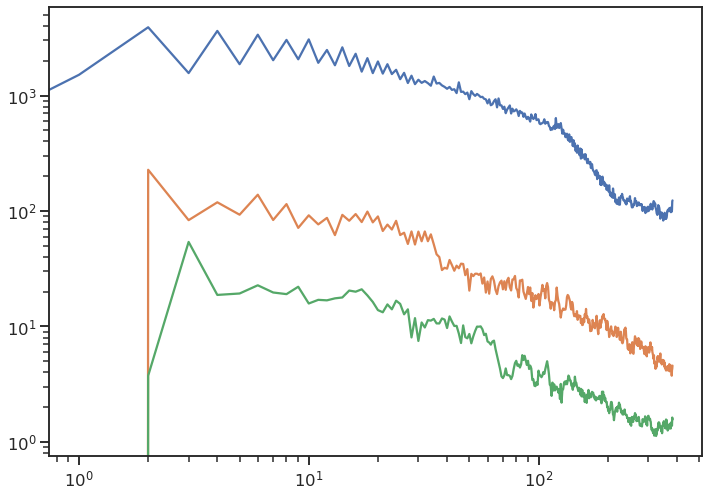

In [48]:
ell = np.arange(len(sl[0]))
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[0])
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[1])
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[2])

In [49]:
ell = np.arange(len(sl[0]))
sl_fake_TT = (1e5*ell[1:].astype(float)**(-2.7))
sl_fake_EE = (3*1e3*ell[1:].astype(float)**(-2.7))
sl_fake_BB = (0.5*1e3*ell[1:].astype(float)**(-2.7))

Text(0.5, 1.0, 'Cl of pure synchrotron at 30GHz')

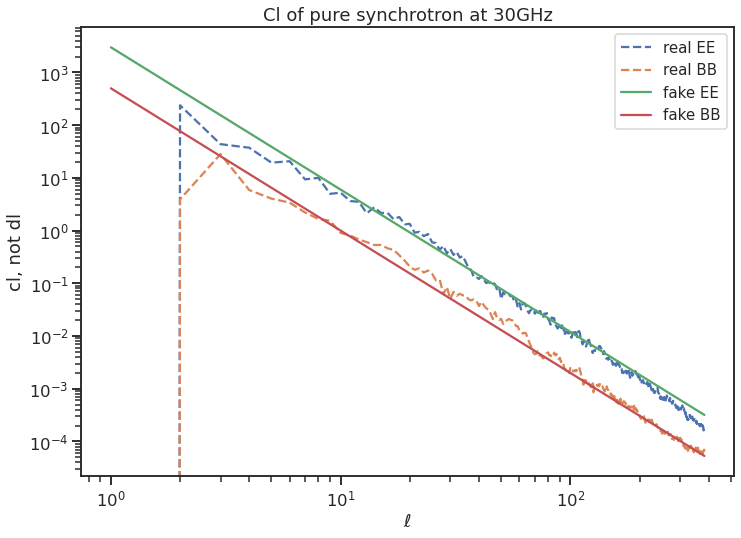

In [45]:
# plt.loglog(ell, sl[0])
plt.loglog(ell, sl[1], '--', label = 'real EE')
plt.loglog(ell, sl[2], '--', label = 'real BB')

# plt.loglog(ell[1:], sl_fake_TT)
plt.loglog(ell[1:], sl_fake_EE, label = 'fake EE')
plt.loglog(ell[1:], sl_fake_BB, label = 'fake BB')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('cl, not dl')

plt.title('Cl of pure synchrotron at 30GHz')

# Full-sky, hp.anafast

In [51]:
sl_fake = np.array((sl_fake_TT, sl_fake_EE, sl_fake_BB, np.zeros_like(sl_fake_TT)))
sync_maps = hp.synfast(sl_fake, nside = nside, new = True)

In [228]:
sl_hat = hp.anafast(sync_maps)

Text(0, 0.5, 'cl, not dl')

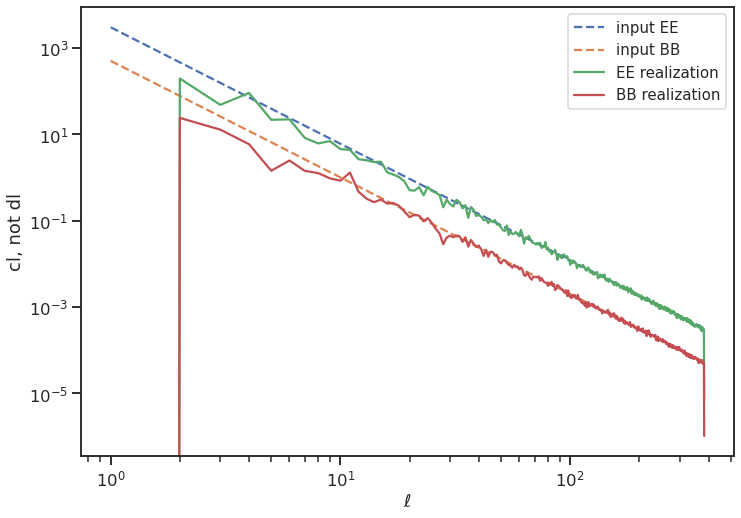

In [233]:
# plt.loglog(ell, sl[0])
# plt.loglog(ell, sl[1])
# plt.loglog(ell, sl[2])

# plt.loglog(ell[1:], sl_fake_TT)
plt.loglog(ell[1:], sl_fake_EE, '--', label = 'input EE')
plt.loglog(ell[1:], sl_fake_BB, '--', label = 'input BB')

# plt.loglog(ell, sl_hat[0])
plt.loglog(ell, sl_hat[1], label = 'EE realization')
plt.loglog(ell, sl_hat[2], label = 'BB realization')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('cl, not dl')

# partial sky, Namaster

In [146]:
est = BPE(mask_128, Nside, 20, 300)

## one map

In [150]:
dl_all = est.Auto_TEB(sync_maps) #TT TE TB EE EB BB.
EE = dl_all[3]; BB = dl_all[5]

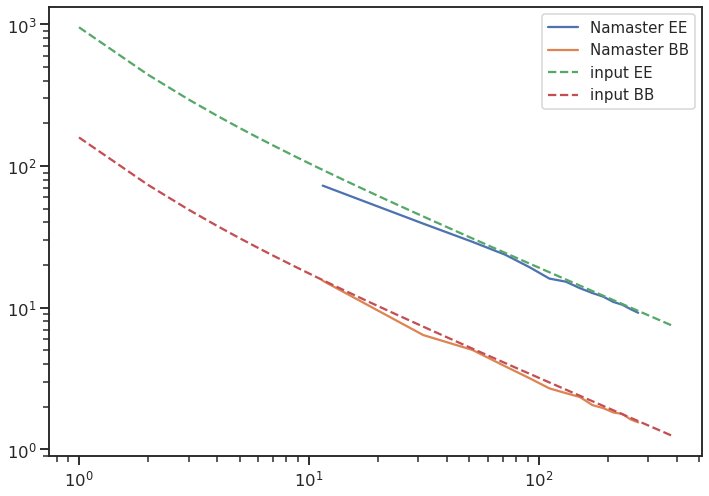

In [164]:
plt.loglog(est.ell_n, EE, label = 'Namaster EE')
plt.loglog(est.ell_n, BB, label = 'Namaster BB')

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('Dl')

## 50 maps

In [165]:
EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = Nside, new = True)
    dl_all = est.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])

In [166]:
EEs = np.array((EEs));BBs = np.array((BBs));

In [170]:
EE_mean = np.mean(EEs, axis = 0)
EE_std = np.std(EEs, axis = 0)
BB_mean = np.mean(BBs, axis = 0)
BB_std = np.std(BBs, axis = 0)

In [174]:
BB_std

array([2.86233424, 0.3862511 , 0.19584326, 0.15081334, 0.11844633,
       0.07943103, 0.05959578, 0.05416717, 0.05000915, 0.0541737 ,
       0.04086276, 0.03804988, 0.03382354, 0.03602194])

In [236]:
# plt.errorbar(est.ell_n, EE_mean, EE_std, label = 'Namaster EE')
# plt.errorbar(est.ell_n, BB_mean, BB_std, label = 'Namaster BB')

plt.loglog(est.ell_n, EE_mean, 'o-', label = 'Namaster EE')
plt.loglog(est.ell_n, BB_mean,'o-', label = 'Namaster BB')
plt.fill_between(est.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.5)
plt.fill_between(est.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.5)

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

# Overlapped region

In [13]:
mask_cbass_256 = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_cbass_256.npy')

mask_both = hp.ud_grade(mask_cbass_256*mask_spass_256, nside_out=128)
mask_both = np.logical_not(np.logical_not(mask_both))

In [14]:
mask_both.sum()/(12*128**2)

0.12993876139322916

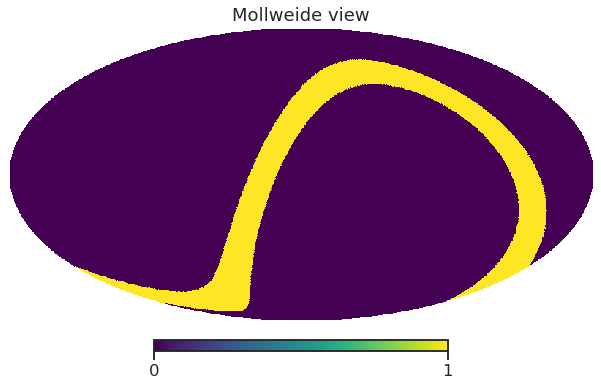

In [10]:
hp.mollview(mask_both, cmap = 'viridis')

In [57]:
est_both = BPE(mask_both, nside, 20, 300)
est_use = est_both
EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = nside, new = True)
    dl_all = est_use.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])
    
EEs = np.array((EEs));BBs = np.array((BBs));

EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0, ddof = 1)
BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0, ddof = 1)

In [55]:
EE_bin = est_use.b.bin_cell(sl_fake_EE[0:301])
BB_bin = est_use.b.bin_cell(sl_fake_BB[0:301])

## using defined functions

In [56]:
pse_results_both = pse(sl_fake, 50, mask_both, 20, 300, kind = 'auto')

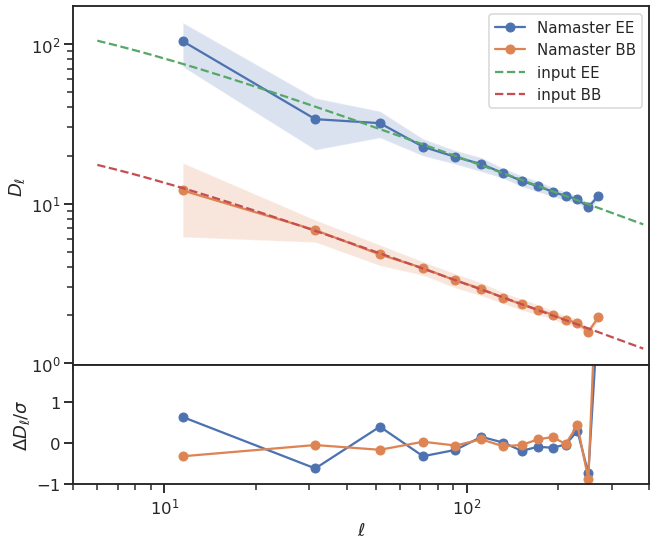

In [58]:
pse_plot(pse_results_both[0], sl_fake, pse_results_both[1])

cosmic variance: $$\Delta C_{\ell} = \sqrt{\frac{2}{(2\ell + 1)\Delta \ell f_{sky}}}  C_{\ell}$$

In [61]:
fsky = 0.13; lbin = 20;
cv_EE = np.sqrt(2/((2*est_use.ell_n + 1)*lbin*fsky))*EE_mean
cv_BB = np.sqrt(2/((2*est_use.ell_n + 1)*lbin*fsky))*BB_mean

In [69]:
EE_std/cv_EE

array([2.30021531, 3.89838042, 2.08568852, 1.82796333, 1.46737048,
       1.64777069, 1.69166631, 1.52700595, 1.62094006, 1.49792126,
       1.48096929, 1.42838818, 1.64243167, 1.19472117])

In [68]:
BB_std/cv_BB

array([3.0965479 , 1.64208166, 1.31177464, 1.51560213, 1.6686709 ,
       1.19394527, 1.86755263, 1.50313733, 1.50455119, 1.52475779,
       1.72371929, 1.59096599, 1.90921944, 1.22645088])

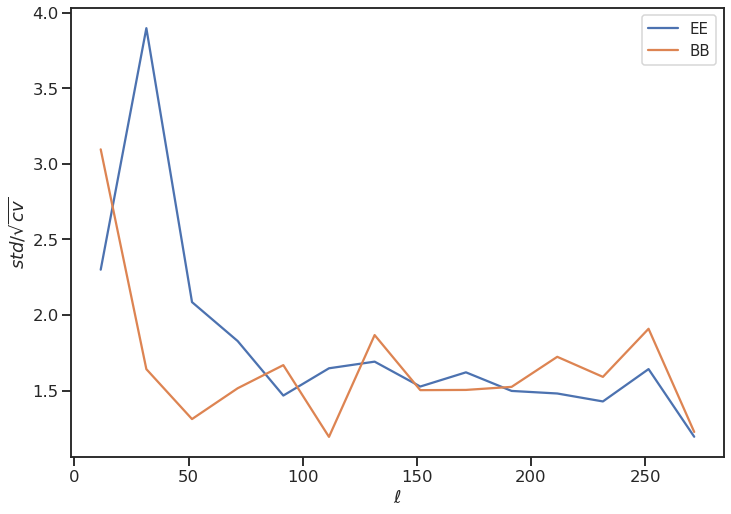

In [74]:
plt.plot(est_use.ell_n, EE_std/cv_EE, label = 'EE')
plt.plot(est_use.ell_n, BB_std/cv_BB, label = 'BB')
plt.xlabel('$\ell$')
plt.ylabel('$std/\sqrt{cv}$')
plt.legend(fontsize = 15)

(5, 400)

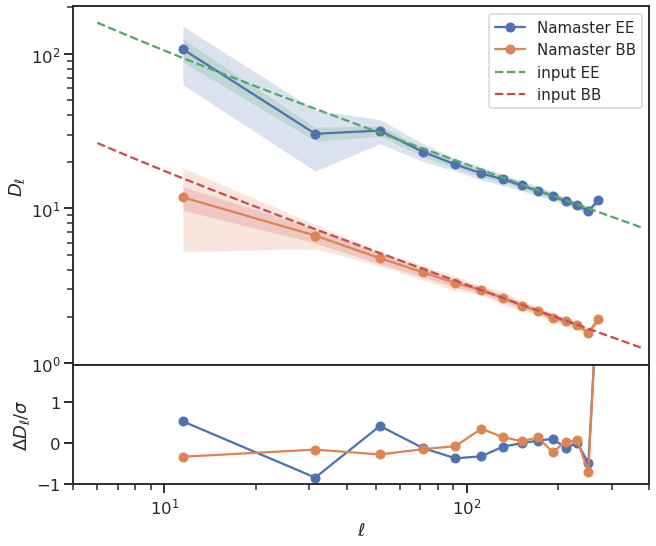

In [63]:
fig1 = plt.figure(1, figsize=(10,8.3))
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.loglog(est_use.ell_n, EE_mean, 'o-', label = 'Namaster EE')
plt.loglog(est_use.ell_n, BB_mean, 'o-', label = 'Namaster BB')
plt.fill_between(est_use.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.2)
plt.fill_between(est_use.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.2)

plt.fill_between(est_use.ell_n, EE_mean - cv_EE, EE_mean + cv_EE, alpha=0.2)
plt.fill_between(est_use.ell_n, BB_mean - cv_BB, BB_mean + cv_BB, alpha=0.2)

plt.loglog(ell[6:], ell[6:]*(ell[6:]+1)/2/np.pi*sl_fake_EE[5:], '--',label = 'input EE')
plt.loglog(ell[6:], ell[6:]*(ell[6:]+1)/2/np.pi*sl_fake_BB[5:], '--',label = 'input BB')
plt.legend(fontsize = 15)
plt.ylabel('$D_{\ell}$')
plt.xlim(5, 400)
frame1.set_xticklabels([])

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.plot(est_use.ell_n, (EE_mean - EE_bin)/EE_std, 'o-', label = 'Namaster EE')
plt.plot(est_use.ell_n, (BB_mean - BB_bin)/BB_std, 'o-', label = 'Namaster BB')
plt.xscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$\Delta D_{\ell} / \sigma$')
plt.ylim(-1,1.9)
plt.xlim(5, 400)

the last one point going up is due to the edge effect, not the real value of ps. If I set the one before the last point as the last point, it still goes up.

# A circular region

25532

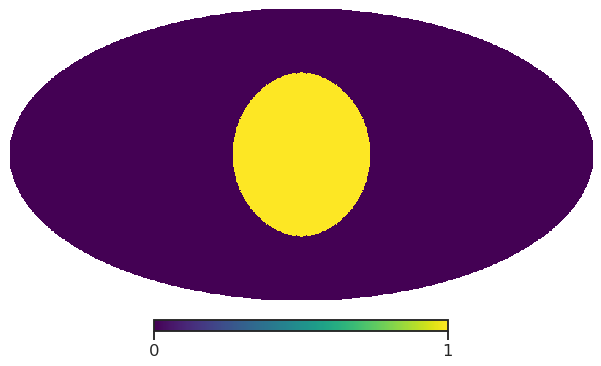

In [17]:
mask_cir = cm.make_mask_total(nside = nside, mask_ring = True, inner = 42.25, outer = 180, ring_b = 0, ring_l = 0)
hp.mollview(mask_cir,title='', cmap = 'viridis')
mask_cir.sum()

In [77]:
est_cir = BPE(mask_cir, nside, 20, 300)
est_use = est_cir
EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = nside, new = True)
    dl_all = est_use.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])
    
EEs = np.array((EEs));BBs = np.array((BBs));

EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0, ddof = 1)
BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0, ddof = 1)

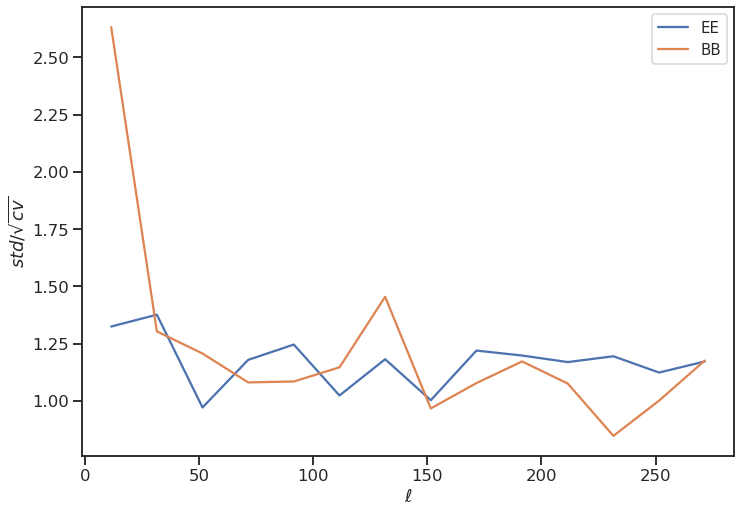

In [78]:
fsky = 0.13; lbin = 20;
cv_EE = np.sqrt(2/((2*est_use.ell_n + 1)*lbin*fsky))*EE_mean
cv_BB = np.sqrt(2/((2*est_use.ell_n + 1)*lbin*fsky))*BB_mean

plt.plot(est_use.ell_n, EE_std/cv_EE, label = 'EE')
plt.plot(est_use.ell_n, BB_std/cv_BB, label = 'BB')
plt.xlabel('$\ell$')
plt.ylabel('$std/\sqrt{cv}$')
plt.legend(fontsize = 15)

## using defined functions

In [53]:
EE_bin = est_use.b.bin_cell(sl_fake_EE[0:301])
BB_bin = est_use.b.bin_cell(sl_fake_BB[0:301])

In [49]:
pse_results_cir = pse(sl_fake, 50, mask_cir, 20, 300, kind = 'auto')

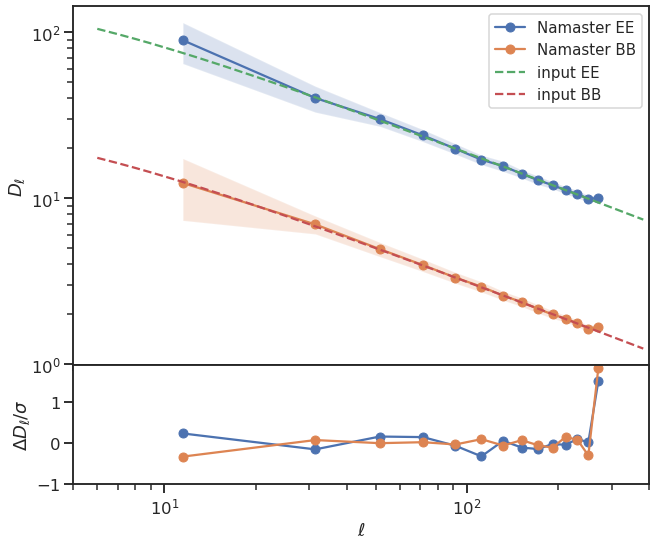

In [54]:
pse_plot(pse_results_cir[0], sl_fake, pse_results_cir[1])

# both region with galactic cut

In [82]:
cut = cm.make_mask_total(nside = nside, l_mask = False, b_mask = True, b_deg_min = -20, b_deg_max = 20)

In [83]:
mask_both_cut = cut*mask_both

In [84]:
mask_both_cut.sum()/(12*nside**2)

0.09678141276041667

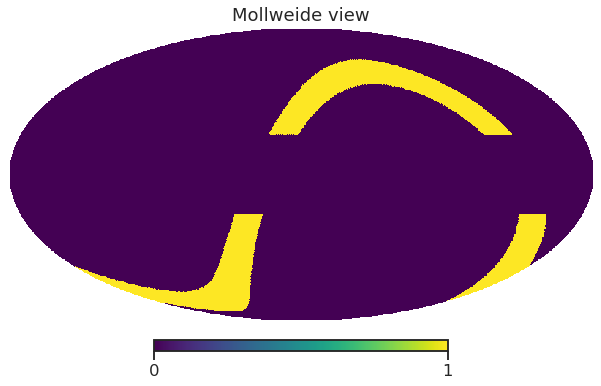

In [19]:
hp.mollview(mask_both_cut, cmap = 'viridis')

In [85]:
pse_results = pse(sl_fake, 50, mask_both_cut, 20, 300, kind = 'auto')

[array([101.34058954,  32.36803319,  30.52205306,  23.43907721,
         19.74643062,  17.25027909,  15.285888  ,  14.30214054,
         12.7054994 ,  12.03763096,  11.20523211,  10.55829906,
          9.67857887,  11.18559493]),
 array([34.04502624, 13.13582247,  5.08768454,  3.72928435,  2.36303357,
         1.80448568,  1.55516091,  1.17989567,  1.09668759,  0.85739751,
         0.88135793,  0.8953428 ,  0.6697172 ,  0.59266454]),
 array([10.94460122,  6.80892985,  4.72840883,  3.94454973,  3.24269939,
         2.84926965,  2.61587275,  2.36003507,  2.17080406,  1.93919613,
         1.88724139,  1.77661931,  1.57445793,  1.93859805]),
 array([7.50348836, 1.20942724, 0.7101216 , 0.54734625, 0.4643329 ,
        0.28185797, 0.31796662, 0.16708569, 0.18058693, 0.13777875,
        0.1327856 , 0.12615297, 0.1366318 , 0.11979222])]

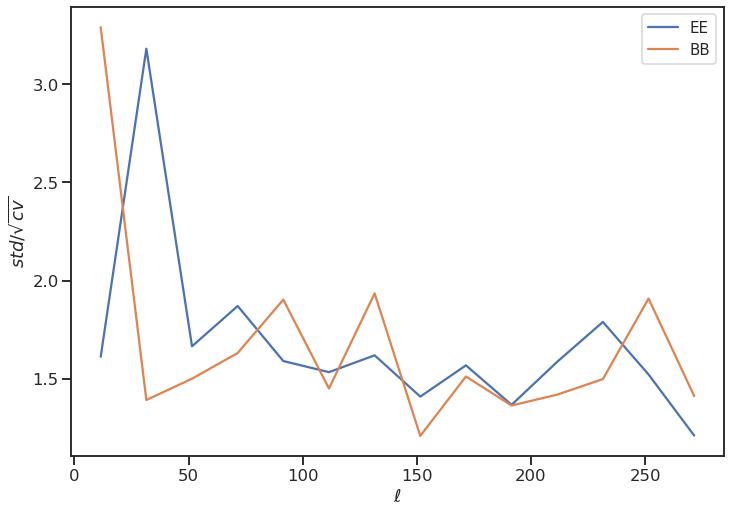

In [89]:
ell_use = pse_results[0]
EE_mean = pse_results[1][0]
EE_std = pse_results[1][1]
BB_mean = pse_results[1][2]
BB_std = pse_results[1][3]

fsky = 0.096; lbin = 20;
cv_EE = np.sqrt(2/((2*ell_use + 1)*lbin*fsky))*EE_mean
cv_BB = np.sqrt(2/((2*ell_use + 1)*lbin*fsky))*BB_mean

plt.plot(ell_use, EE_std/cv_EE, label = 'EE')
plt.plot(ell_use, BB_std/cv_BB, label = 'BB')
plt.xlabel('$\ell$')
plt.ylabel('$std/\sqrt{cv}$')
plt.legend(fontsize = 15)

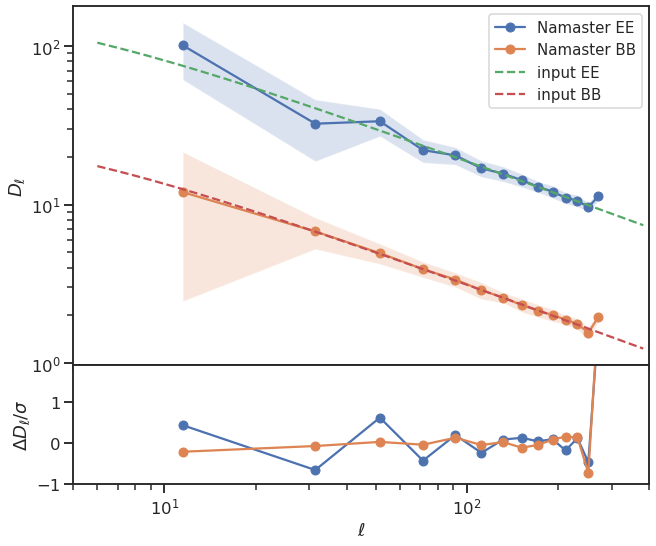

In [443]:
pse_plot(pse_results[0], sl_fake, pse_results[1])

# Auto and Cross power spectrum with noise

In [12]:
sky = pysm3.Sky(nside=nside, preset_strings=["s0"])
spass_signal = sky.get_emission(2.3 * u.GHz)
cbass_signal = sky.get_emission(5 * u.GHz)

In [15]:
est_auto = BPE(mask_both, nside, 20, 300)

In [25]:
Nl_spass = est_auto.Auto_TEB(noise_128_i[0])
Nl_cbass = est_auto.Auto_TEB(noise_128_i[1])

In [27]:
spass_obs = np.array((spass_signal)) + noise_128_i[0]
cbass_obs = np.array((cbass_signal)) + noise_128_i[1]
spass_1 = est_auto.Auto_TEB(spass_obs)
# cbass_1 = est_auto.Auto_TEB(cbass_obs)

In [403]:
spass_obs = np.array((spass_signal)) + noise_128_i[0]
cbass_obs = np.array((cbass_signal)) + noise_128_i[1]
cross_maps = [spass_obs[1:3], cbass_obs[1:3]]
spass_2 = est_auto.Cross_EB(cross_maps)

In [404]:
spass_1[3]

array([-2.05320250e+07,  2.92844874e+08,  9.74498009e+07,  2.26383260e+08,
        1.09046260e+08,  1.17644075e+08,  1.47995868e+08,  9.63522555e+07,
        6.33100825e+07,  7.16775564e+07,  7.51239961e+07,  6.05107780e+07,
        4.55097116e+07,  7.40602334e+07])

In [405]:
spass_1[5]

array([2.95328847e+08, 2.69289746e+07, 7.41816361e+07, 2.70655602e+07,
       2.60745582e+07, 2.04421666e+07, 3.01451444e+07, 1.43632071e+07,
       1.54221833e+07, 1.67697728e+07, 1.37498383e+07, 1.24889956e+07,
       1.23864953e+07, 1.64980025e+07])

In [406]:
spass_2[0][:,0,0]

array([-2.05320250e+07,  2.92844874e+08,  9.74498009e+07,  2.26383260e+08,
        1.09046260e+08,  1.17644075e+08,  1.47995868e+08,  9.63522555e+07,
        6.33100825e+07,  7.16775564e+07,  7.51239961e+07,  6.05107780e+07,
        4.55097116e+07,  7.40602334e+07])

In [409]:
spass_2[2][:,0,0]

array([2.95328847e+08, 2.69289746e+07, 7.41816361e+07, 2.70655602e+07,
       2.60745582e+07, 2.04421666e+07, 3.01451444e+07, 1.43632071e+07,
       1.54221833e+07, 1.67697728e+07, 1.37498383e+07, 1.24889956e+07,
       1.23864953e+07, 1.64980025e+07])

In [22]:
EEs_spa = []; BBs_spa = []; EEs_cba = []; BBs_cba = []; EE_cross = []; BB_cross = []
for i in range(5):
    noise_128_i = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/nside_128/5_fre_noise_%s_uK_RJ_%03d.npy'%(nside, i))
    spass_obs = np.array((spass_signal)) + noise_128_i[0]
    cbass_obs = np.array((cbass_signal)) + noise_128_i[1]
    
    cross_maps = [spass_obs[1:], cbass_obs[1:]]
    dl_all = est_auto.Cross_EB(cross_maps)
    EEs_spa.append(dl_all[0][:,0,0]); BBs_spa.append(dl_all[2][:,0,0])
    EEs_cba.append(dl_all[0][:,1,1]); BBs_cba.append(dl_all[2][:,1,1])
    EE_cross.append(dl_all[0][:, 0, 1]); BB_cross.append(dl_all[2][:, 0, 1])

In [23]:
def get_mean_and_std(EE, BB):
    EE = np.array((EE)); BB = np.array((BB));
    EE_mean = np.mean(EE, axis = 0); EE_std = np.std(EE, axis = 0, ddof = 1);
    BB_mean = np.mean(BB, axis = 0); BB_std = np.std(BB, axis = 0, ddof = 1);
    
    return EE_mean, EE_std, BB_mean, BB_std

In [24]:
EE_spa_mean , EE_spa_std, BB_spa_mean, BB_spa_std = get_mean_and_std(EEs_spa, BBs_spa)
EE_cba_mean , EE_cba_std, BB_cba_mean, BB_cba_std = get_mean_and_std(EEs_cba, BBs_cba)
EE_cro_mean , EE_cro_std, BB_cro_mean, BB_cro_std = get_mean_and_std(EE_cross, BB_cross)

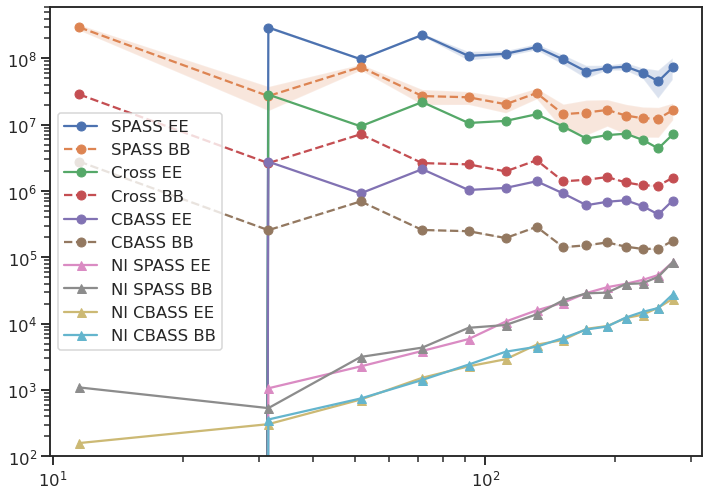

In [42]:
ells = est_auto.ell_n

plt.loglog(ells, EE_spa_mean, 'o-', label = 'SPASS EE')
plt.fill_between(ells, EE_spa_mean - EE_spa_std, EE_spa_mean + EE_spa_std, alpha=0.2)

plt.loglog(ells, BB_spa_mean, 'o--', label = 'SPASS BB')
plt.fill_between(ells, BB_spa_mean - BB_spa_std, BB_spa_mean + BB_spa_std, alpha=0.2)

plt.loglog(ells, EE_cro_mean, 'o-', label = 'Cross EE')
plt.fill_between(ells, EE_cro_mean - EE_cro_std, EE_cro_mean + EE_cro_std, alpha=0.2)

plt.loglog(ells, BB_cro_mean, 'o--', label = 'Cross BB')
plt.fill_between(ells, BB_cro_mean - BB_cro_std, BB_cro_mean + BB_cro_std, alpha=0.2)

plt.loglog(ells, EE_cba_mean, 'o-', label = 'CBASS EE')
plt.fill_between(ells, EE_cba_mean - EE_cba_std, EE_cba_mean + EE_cba_std, alpha=0.2)

plt.loglog(ells, BB_cba_mean, 'o--', label = 'CBASS BB')
plt.fill_between(ells, BB_cba_mean - BB_cba_std, BB_cba_mean + BB_cba_std, alpha=0.2)

# plt.loglog(ells, spass_1[3])
# plt.loglog(ells, spass_2[3])

# plt.loglog(ells, spass_1[5])
# plt.loglog(ells, spass_2[5])

plt.loglog(ells, Nl_spass[3], '^-', label = 'Nl SPASS EE')
plt.loglog(ells, Nl_spass[5], '^-', label = 'Nl SPASS BB')

plt.loglog(ells, Nl_cbass[3], '^-', label = 'Nl CBASS EE')
plt.loglog(ells, Nl_cbass[5], '^-', label = 'Nl CBASS BB')
plt.ylim(1e2, 6*1e8)
plt.legend()

# Cross power spetrum between SPASS and CBASS with noise

In [318]:
sky = pysm3.Sky(nside=Nside, preset_strings=["s0"])
spass_signal = sky.get_emission(2.3 * u.GHz)
spass_signal = np.array((spass_signal))

In [276]:
noise_128_i = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/nside_128/5_fre_noise_%s_uK_RJ_%03d.npy'%(Nside, 0))

In [331]:
spass_obs = spass_signal + noise_128_i[0] ## reset the input as the real input every time!!!
f_2 = nmt.NmtField(mask_both, spass_obs[1:3], purify_e = False, purify_b = True)
b = nmt.NmtBin.from_nside_linear(Nside, 4)
cl_22 = nmt.compute_full_master(f_2, f_2, b)

In [ ]:
est_cross = BPE(mask_both, Nside, 20, 300)

In [389]:
cross_maps = [spass_signal[1:], cbass_signal[1:]]

In [390]:
dls = est_cross.Cross_EB(cross_maps)

In [396]:
dls[2][:,0,1]/np.sqrt(dls[2][:,0,0]*dls[2][:,1,1])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [402]:
dls[0][:,0,1]/np.sqrt(dls[0][:,0,0]*dls[0][:,1,1])

array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.])

# utility functions

In [52]:
def pse(input_ps, N, mask_in, bin_width, lmax, kind = 'auto'):
    '''
    Parameters
    ----------
    input_ps: fake PS
    bin_width: bin width to calculate the band power.
    lmax: the max-ell to calculate the power spectrum
    N: the number of map realizations generated to calculate the power spetrum.
    
    Returns
    -------
    ell_n: effective ell for the estimator
    EE_mean: mean EE from N realizations of maps
    EE_std;
    BB_mean
    BB_std

    '''
    nside = hp.get_nside(mask_in)
    
    est = BPE(mask_in, nside, bin_width, lmax)
    if kind == 'auto':
        calculator = est.Auto_TEB
    if kind == 'cross':
        calculator = est.Cross_EB
        
    EEs = []; BBs = []
    for i in range(N):
        sync_maps_i = hp.synfast(input_ps, nside = nside, new = True)
        dl_all = calculator(sync_maps_i) #TT TE TB EE EB BB.
        EEs.append(dl_all[3]); BBs.append(dl_all[5])

    EEs = np.array((EEs));BBs = np.array((BBs));

    EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0, ddof = 1)
    BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0, ddof = 1)
    
    return est.ell_n, [EE_mean, EE_std, BB_mean, BB_std]

def pse_plot(ell, input_ps, pse_results, EE_bin, BB_bin):
    '''
    Parameters
    ----------
    ell: effective ells
    pse_results: pse return[1]
    '''
    EE_mean, EE_std, BB_mean, BB_std = pse_results
    
    fig1 = plt.figure(1, figsize=(10,8.3))
    frame1=fig1.add_axes((.1,.3,.8,.6))

    plt.loglog(ell, EE_mean, 'o-', label = 'Namaster EE')
    plt.loglog(ell, BB_mean, 'o-', label = 'Namaster BB')
    plt.fill_between(ell, EE_mean - EE_std, EE_mean + EE_std, alpha=0.2)
    plt.fill_between(ell, BB_mean - BB_std, BB_mean + BB_std, alpha=0.2)
    
    ell_l = np.arange(1, len(input_ps[1]))
    
    plt.loglog(ell_l[5:], ell_l[5:]*(ell_l[5:]+1)/2/np.pi*input_ps[1][6:], '--',label = 'input EE')
    plt.loglog(ell_l[5:], ell_l[5:]*(ell_l[5:]+1)/2/np.pi*input_ps[2][6:], '--',label = 'input BB')
    
    plt.legend(fontsize = 15)
    plt.ylabel('$D_{\ell}$')
    plt.xlim(5, 400)
    frame1.set_xticklabels([])

    frame2=fig1.add_axes((.1,.1,.8,.2))
    plt.plot(ell, (EE_mean - EE_bin)/EE_std, 'o-', label = 'Namaster EE')
    plt.plot(ell, (BB_mean - BB_bin)/BB_std, 'o-', label = 'Namaster BB')
    plt.xscale('log')
    plt.xlabel('$\ell$')
    plt.ylabel('$\Delta D_{\ell} / \sigma$')
    plt.xlim(5, 400)
    plt.ylim(-1,1.9)